# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [ ]:
import pandas as pd

In [ ]:
data_filename = "data.csv"
data_path = data_filename

In [ ]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [ ]:
data.shape

(31390, 4)

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 31390 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  31390 non-null  object 
 1   pH                31104 non-null  float64
 2   data_source       28043 non-null  object 
 3   tm                31390 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


## EDA

In [ ]:
data.isna().sum()

protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

В данных есть пропущенные значения. Значение pH напрямую влияет на стабильность белка, поэтому возьмем только данные для которых есть значения pH. 

In [ ]:
data.pH.unique()

array([ 7.  ,  5.  ,  7.5 ,   nan,  7.4 , 48.4 , 49.  , 55.6 ,  6.2 ,
        5.5 ,  6.3 ,  2.  ,  8.5 ,  3.  ,  6.8 ,  6.4 ,  6.6 ,  6.7 ,
        6.5 ,  4.5 ,  8.  ,  7.3 ,  7.2 ,  8.4 ,  8.1 ,  9.6 ,  5.9 ,
        6.  ,  4.  ,  3.5 ,  4.2 ,  5.1 ,  3.6 ,  7.1 ,  7.8 ,  9.  ,
        3.2 ,  2.5 ,  2.8 ,  5.2 ,  5.4 ,  5.8 ,  7.7 ,  7.6 , 10.  ,
        8.2 ,  2.7 ,  2.9 ,  3.1 , 64.9 ,  3.14,  2.53,  2.3 ,  2.2 ,
        2.81,  8.25,  9.9 ,  9.5 , 10.4 ,  9.08,  8.7 ,  3.7 , 39.  ,
        4.6 ,  4.4 ,  5.35,  5.7 ,  9.2 ,  5.38,  5.28,  6.9 ,  5.42,
        5.3 ,  6.1 ,  9.7 ,  8.6 ,  4.8 ,  6.78,  5.31,  3.02,  4.9 ,
        4.3 ,  5.45,  3.01,  3.3 ,  3.8 ,  2.4 ,  2.84,  2.34,  4.7 ,
        2.1 ,  3.9 ,  2.02,  2.83,  2.03,  2.86,  1.99,  8.3 , 53.4 ,
        3.16,  2.94,  9.75,  3.15,  3.07,  3.04,  3.25,  3.21,  2.98,
        3.19,  4.1 ,  5.6 ,  3.75,  4.75,  4.25, 11.  , 10.3 ])

In [ ]:
data1 = data.dropna(subset=['pH'])
data.shape[0] - data1.shape[0]

286

In [ ]:
print(data1.describe())

                 pH            tm
count  31104.000000  31104.000000
mean       6.892339     49.150608
std        1.612225     14.044705
min        1.990000     -1.000000
25%        7.000000     42.100000
50%        7.000000     48.100000
75%        7.000000     53.800000
max       64.900000    130.000000


Интервал значений pH и Tm вызывает сомнения. 
* Интервал температуры плавления неожиданный. Не знаю метода исследования, могу предположить, что измерение проводилось в водной среде при нормальном давлении, поэтому отрицательные значения и значения выше 100 град. убираем. 
* pH может быть более 14, однако врядли в эксперименте с белками использовался настолько щелочной буффер. Поэтому будем учитывать значения pH до 14-ти.
Беру на себя ответственность убрать экспериментальные данные с сомнительными параметрами.

In [ ]:
data2 = data1.drop(data1[(data1.pH > 14) | (data1.tm < 0) | (data1.tm > 100)].index)
data2.describe()

,pH,tm
count,31067.000000,31067.000000
mean,6.850902,49.179206
std,0.859405,13.953180
min,1.990000,0.000000
25%,7.000000,42.100000
50%,7.000000,48.100000
75%,7.000000,53.800000
max,11.000000,99.000000


Теперь значения параметров похожи на реальные.

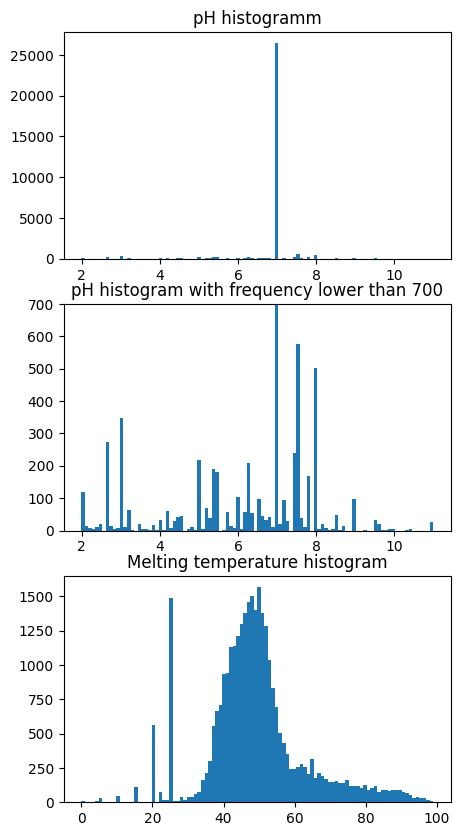

In [ ]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5,10))
ax0.set_title('pH histogramm')
ax0.hist(data2.pH, bins=100)
ax1.set_title('pH histogram with frequency lower than 700') 
ax1.hist(data2.pH, bins=100)
ax1.set_ylim([0,700])
ax2.set_title('Melting temperature histogram')
ax2.hist(data2.tm, bins=100)
plt.show()

По гистограме видно что присутствует большое кол-во результатов при нейтральном pH (~7). Так же есть много наблюдений от 2 до 10. Думаю получится построить модель, которая хорошо сможет предказывать в этом регионе.
Для температуры плавления, наблюдается две моды. Попробуем посмотреть на температуру плавления на белках при нейтральном pH.

,pH,tm
count,27641.000000,27641.000000
mean,7.011829,49.722463
std,0.089409,13.149867
min,6.500000,0.000000
25%,7.000000,42.700000
50%,7.000000,48.100000
75%,7.000000,53.400000
max,7.500000,99.000000


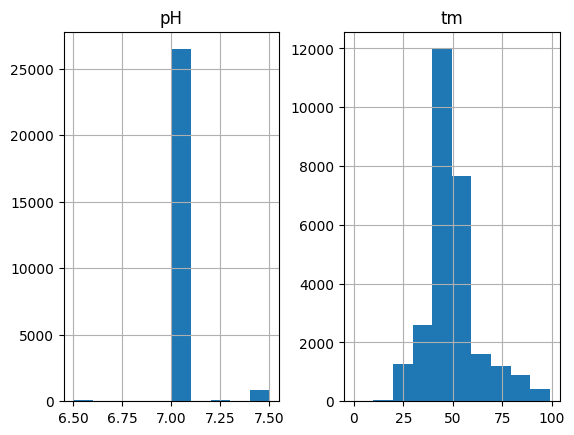

In [ ]:
data3 = data2.drop(data2[(data2.pH < 6.5) | (data2.pH > 7.5)].index)
data3.hist()
data3.describe()

Один пик наблюдается при нейтральном pH. Проверем при каком pH наблюдается второй.

,pH,tm
count,1523.000000,1523.000000
mean,6.390164,24.977938
std,1.573140,0.201503
min,2.000000,23.000000
25%,5.500000,25.000000
50%,7.000000,25.000000
75%,7.400000,25.000000
max,9.000000,26.000000


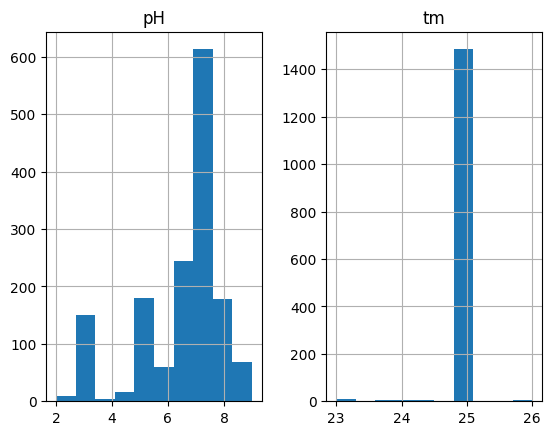

In [ ]:
data4 = data2.drop(data2[(data2.tm < 23) | (data2.tm > 26)].index)
data4.hist()
data4.describe()

Я хотел увидеть иное, но ожидаемый результат. второй пик тоже соответсвует нейтральному pH. Вимо дело в самой природе белка. Мб в длине первичной структры.

In [ ]:
data3.columns

Index(['protein_sequence', 'pH', 'data_source', 'tm'], dtype='object')

In [39]:
print('First peak')
print(data3['protein_sequence'].str.len().mean())
print(data3['protein_sequence'].str.len().std())
print('Second peak')
print(data4['protein_sequence'].str.len().mean())
print(data4['protein_sequence'].str.len().std())

First peak
470.1429760138924
666.8817348661418
Second peak
503.06369008535785
2267.1511592722545


Нет. дело не в длине. Внутри групп они совсем разные встречаются ._. 
Пропустим этот вопрос, он второстепенный

## Encoding amino acids
Есть несколько вариантов представить последовательность мномеров в числовом виде.
 * “one-hot encoding”
 * the BLOck SUbstitution Matrix (BLOSUM)
 * the principal components score Vectors of Hydrophobic, Steric, and Electronic properties (VHSE8).
И есть много статей по сравнению и новым предложениям. Среди пары пакетов на питон нашел [seqvec](https://pypi.org/project/seqvec/) выглядит убедительно с 94-мя звездами. Попробуем его. 

In [40]:
! pip install bio-embeddings

  Using cached bio_embeddings-0.1.6-py3-none-any.whl (73 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached biopython-1.81-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  Using cached importlib_metadata-1.7.0-py2.py3-none-any.whl (31 kB)
INFO: pip is looking at multiple versions of bio-embeddings to determine which version is compatible with other requirements. This could take a while.
  Using cached bio_embeddings-0.1.5-py3-none-any.whl (72 kB)
  Using cached bio_embeddings-0.1.4-py3-none-any.whl (84 kB)
  Using cached lock-2018.3.25.2110.tar.gz (3.0 kB)
  Preparing metadata (setup.py) ... done
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
  Using cached ruamel

In [41]:
pip bio_embeddings 

ERROR: unknown command "bio_embeddings"
Note: you may need to restart the kernel to use updated packages.


In [42]:
from bio_embeddings.embed import SeqVecEmbedder

embedder = SeqVecEmbedder()

embedding = embedder.embed("SEQVENCE")

ModuleNotFoundError: No module named 'bio_embeddings'